In [1]:
import sys
import requests
import zipfile
import urllib3
import matplotlib
import re
import numpy as np

from pathlib import Path
from os import getcwd, makedirs, rename
from os.path import join, basename, isdir, isfile

sys.path.append(str(Path(getcwd()).parent))
current_dir = getcwd()
print(current_dir)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

urllib3.disable_warnings()

/home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/notebooks


In [2]:
class Dados:
    def __init__(self):
        dicionarioDados = pd.read_csv(join(Path(getcwd()).parent,'dicionario_dados.csv'), sep = ";")
        self.schema = dicionarioDados
        self.municipios = pd.read_csv(join(Path(getcwd()).parent,'dados','Municipios-Brasileiros'), sep = ",", usecols=[0,2,3]).rename(columns={'codigo_ibge':'CO_MUNICIPIO', 'latitude':'LATITUDE', 'longitude':'LONGITUDE'})
        self.parser = dict([[column, eval(parser.replace("“","\"").replace("”","\""))] for column, parser in dicionarioDados.loc[(dicionarioDados['TRADUCAO'].notna()),['COLUNA','TRADUCAO']].values])
        self.fillna = dict(dicionarioDados.loc[dicionarioDados['NULO'].notna(),['COLUNA','NULO']].values)
        self.dtypes = dict(dicionarioDados[['COLUNA','TIPOS']].values)
        self.meaning = dict(dicionarioDados[['COLUNA', 'DESCRICAO']])

    def traduzDados(self):
        print("Iniciando merge das variaveis com o dicionário de dados")
        for col in self.schema.loc[self.schema['NULO'].notna(),'COLUNA'].values:
            self.DataFrame[col] = self.DataFrame[col].fillna(self.fillna[col]).astype(self.dtypes[col])

        for col in self.schema.loc[self.schema['TRADUCAO'].notna(),'COLUNA'].values:
            self.DataFrame.replace(self.parser,inplace=True)

    def baixaDados(self, url, endereco=None):
        if not isdir(join(Path(getcwd()).parent,"dados")):
            makedirs(join(Path(getcwd()).parent,"dados"))
        if not isfile(join(Path(getcwd()).parent,"dados", basename(url.split("/")[4]))):
            if endereco is None:
                endereco = join(Path(getcwd()).parent,"dados", basename(url.split("/")[4]))
            resposta = requests.get(url, stream=True, verify=False)
            if resposta.status_code == requests.codes.OK:
                with open(endereco, 'wb') as novo_arquivo:
                        for parte in resposta.iter_content(chunk_size=256):
                            novo_arquivo.write(parte)
                print("Download finalizado. Arquivo salvo em: {}".format(endereco))
                if ('zip' in endereco) and not isdir(join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip",""))):
                    with zipfile.ZipFile(join(Path(getcwd()).parent,"dados", basename(url.split("/")[4])), 'r') as zip_ref:
                        zip_ref.extractall(join(Path(getcwd()).parent,"dados"))
                    rename(join(Path(getcwd()).parent,"dados","Microdados do Censo da Educaç╞o Superior 2020"),join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip","")))
            else:
                resposta.raise_for_status()

    def importaDados(self, entrada="MICRODADOS_CADASTRO_CURSOS_2020.CSV"):
        print("Iniciando leitura do arquivo {}".format(entrada))
        self.baixaDados("https://download.inep.gov.br/microdados/microdados_censo_da_educacao_superior_2020.zip")
        self.baixaDados("https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/main/csv/municipios.csv")
        caminho_entrada = join(Path(getcwd()).parent,"dados","microdados_censo_da_educacao_superior_2020", "dados")
        self.DataFrame = pd.read_csv(join(caminho_entrada,str(entrada).split(",")[0]), sep = ';', low_memory = False, encoding = 'latin-1').reset_index()
        count = 0
        for arquivo in str(entrada).replace(" ","").split(","):
            if count == 0:
                count = count+1
            else:
                self.DataFrame.merge(pd.read_csv(join(caminho_entrada,arquivo), sep = ';', low_memory = False, encoding = 'latin-1').reset_index(), how = 'left', on = 'index')
        self.DataFrame = self.DataFrame.set_index('index')

class Individuo:
    def __init__(self, nome):
        self.nome = nome
        self.cor = None
        self.sexo = None
        self.faixa_etaria = None
        self.dicIntervaloModal = None
        self.tabelaMedidasResumo = None

    def alteraNomeColunas(self):
        dicIndividuo = {'ingressantes':'QT_ING_', 'concluintes':'QT_CONC_','matriculados':'QT_MAT_'}
        self.cor.columns = [re.sub(dicIndividuo[self.nome],'',coluna) for coluna in self.cor.columns.values]
        self.sexo.columns = [re.sub(dicIndividuo[self.nome],'',coluna) for coluna in self.sexo.columns.values]
        self.faixa_etaria.columns = [tuple(re.sub(dicIndividuo[self.nome],'',coluna).replace('MAIS','69').split('_')) for coluna in self.faixa_etaria.columns.values]

    def IntervaloModal(self, variavelAgrupamento):
        self.tabelaMedidasResumo = self.faixa_etaria.groupby(variavelAgrupamento).sum().transpose()
        self.dicIntervaloModal = {coluna:self.tabelaMedidasResumo.reset_index().loc[self.tabelaMedidasResumo.reset_index()[coluna] == self.tabelaMedidasResumo.reset_index()[coluna].max(), 'index'].index[0] for coluna in self.tabelaMedidasResumo.columns.values}

    def Moda(self, local, variavelAgrupamento):
        self.IntervaloModal(variavelAgrupamento)
        variacao_anterior = self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].values[0] - self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]-1]][local].values[0] if (self.dicIntervaloModal[local] in range(1,7)) else self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].values[0]
        variacao_posterior = self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].values[0] - self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]+1]][local].values[0] if (self.dicIntervaloModal[local] in range(1,7)) else self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].values[0]
        limite_inferior = int(self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].index[0][0])
        amplitude = int(self.tabelaMedidasResumo.iloc[[self.dicIntervaloModal[local]]][local].index[0][1])+1 - limite_inferior
        denominador = variacao_anterior+variacao_posterior
        return limite_inferior+((variacao_anterior*amplitude)/denominador) if (variacao_anterior+variacao_posterior > 0) else 0

    def Media(self, local, variavelAgrupamento):
        valor_medio = [(int(tupla[1])+1+int(tupla[0]))/2 for tupla in self.faixa_etaria.groupby(variavelAgrupamento).sum().columns]
        faixa_etaria = self.faixa_etaria.groupby(variavelAgrupamento).sum().loc[self.faixa_etaria.groupby(variavelAgrupamento).sum().index == local].values[0]
        return sum([x*y for x,y in zip(valor_medio, faixa_etaria)])/sum(faixa_etaria) if (sum(faixa_etaria) > 0) else 0
    


In [3]:
dados = Dados()
dados.importaDados("MICRODADOS_CADASTRO_CURSOS_2020.CSV")
dados.traduzDados()

Iniciando leitura do arquivo MICRODADOS_CADASTRO_CURSOS_2020.CSV
Iniciando merge das variaveis com o dicionário de dados


In [4]:
UniversidadePublica = dados.DataFrame.loc[(dados.DataFrame.TP_ORGANIZACAO_ACADEMICA == 'Universidade') & (dados.DataFrame.TP_REDE == 'Pública')]
print('Cursos de universidades públicas: {}/{}'.format(UniversidadePublica.shape[0], dados.DataFrame.shape[0]))

Cursos de universidades públicas: 13220/335629


In [5]:
ingressantes = Individuo('ingressantes')
ingressantes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
ingressantes.sexo = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
ingressantes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
ingressantes.alteraNomeColunas()

concluintes = Individuo('concluintes')
concluintes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
concluintes.sexo = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
concluintes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF', 'CO_MUNICIPIO'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
concluintes.alteraNomeColunas()

array([<AxesSubplot: title={'center': 'Centro-Oeste'}>,
       <AxesSubplot: title={'center': 'Nordeste'}>,
       <AxesSubplot: title={'center': 'Norte'}>,
       <AxesSubplot: title={'center': 'Sudeste'}>,
       <AxesSubplot: title={'center': 'Sul'}>], dtype=object)

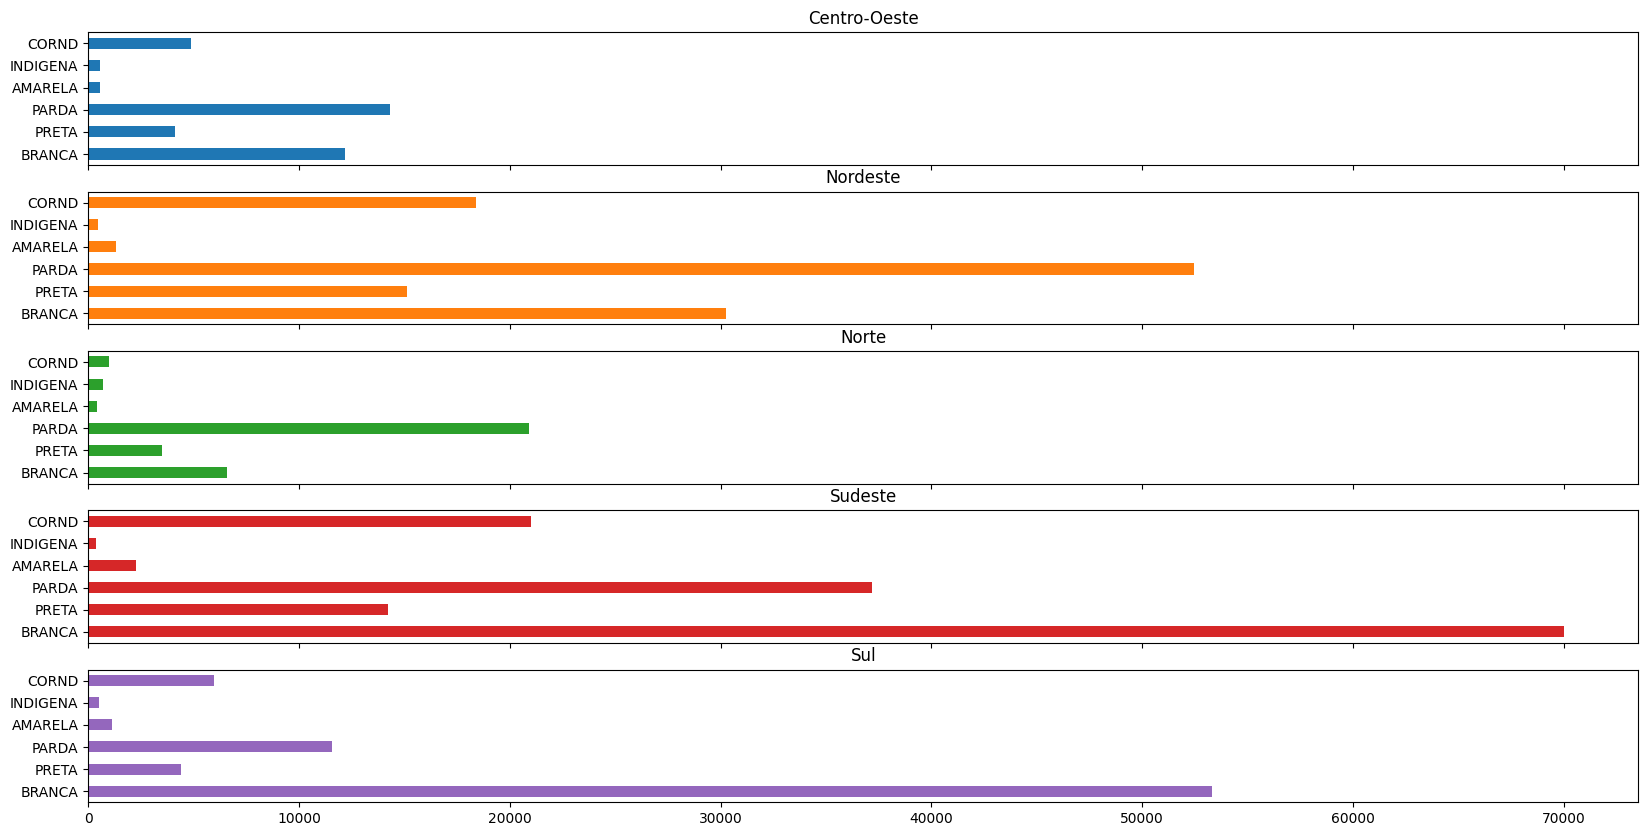

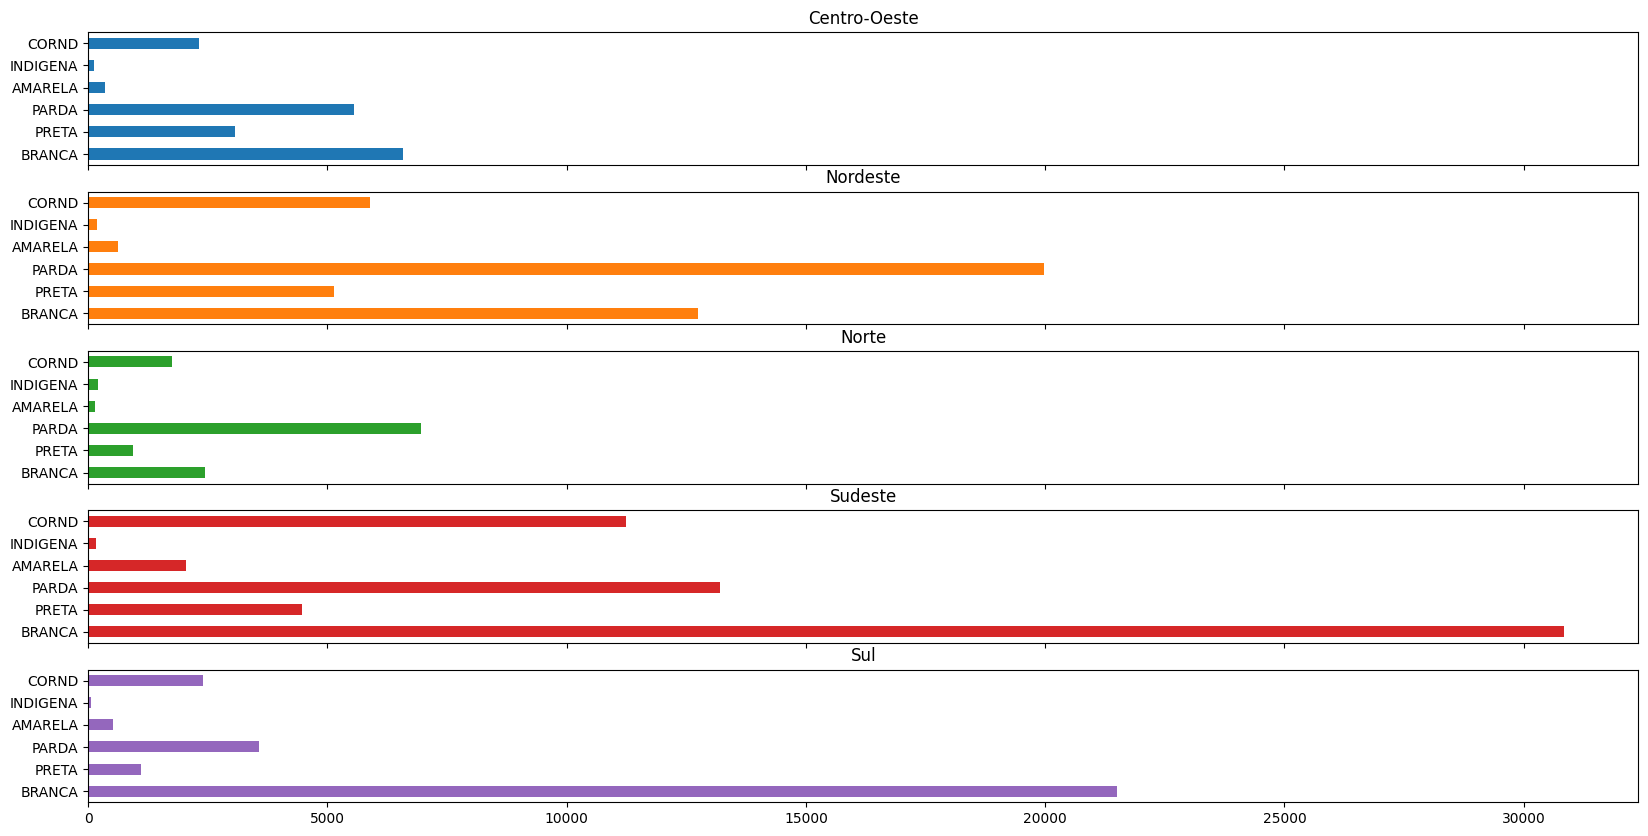

In [6]:
ingressantes.cor.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))
concluintes.cor.groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))

array([<AxesSubplot: ylabel='Centro-Oeste'>,
       <AxesSubplot: ylabel='Nordeste'>, <AxesSubplot: ylabel='Norte'>,
       <AxesSubplot: ylabel='Sudeste'>, <AxesSubplot: ylabel='Sul'>],
      dtype=object)

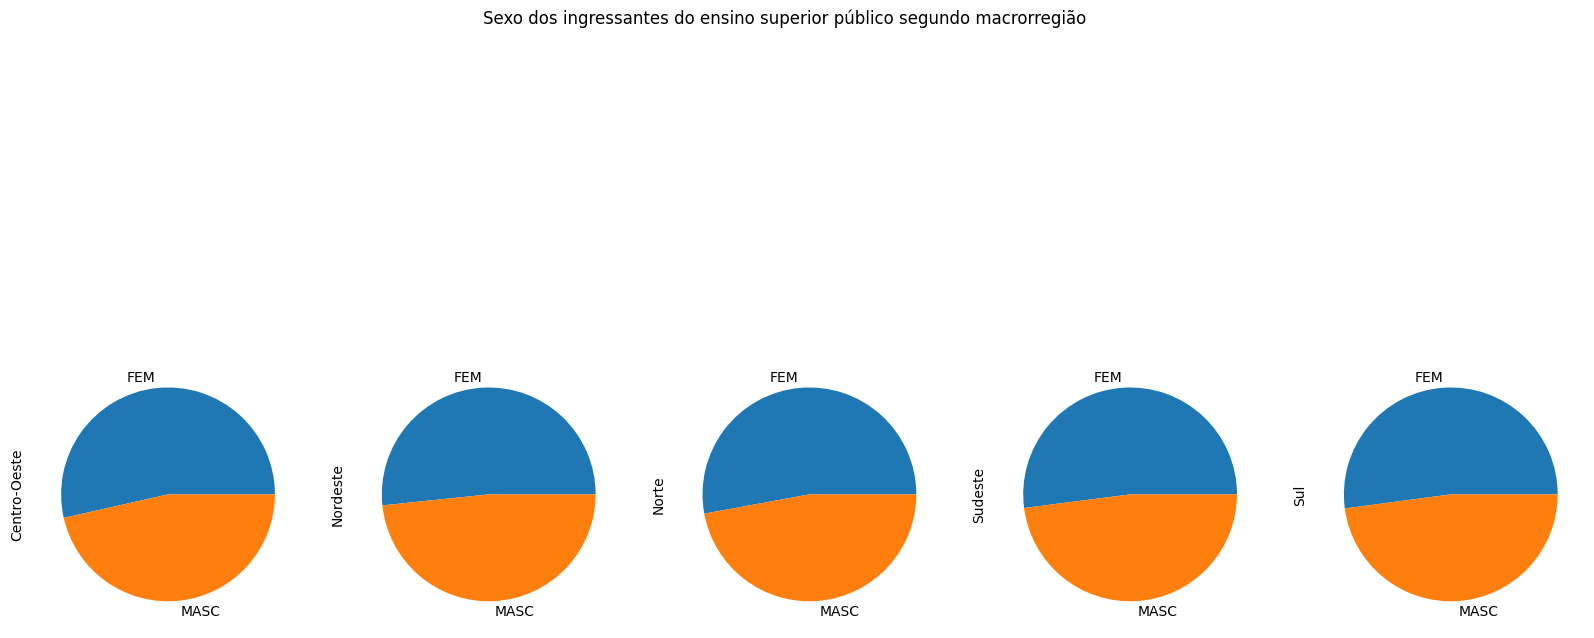

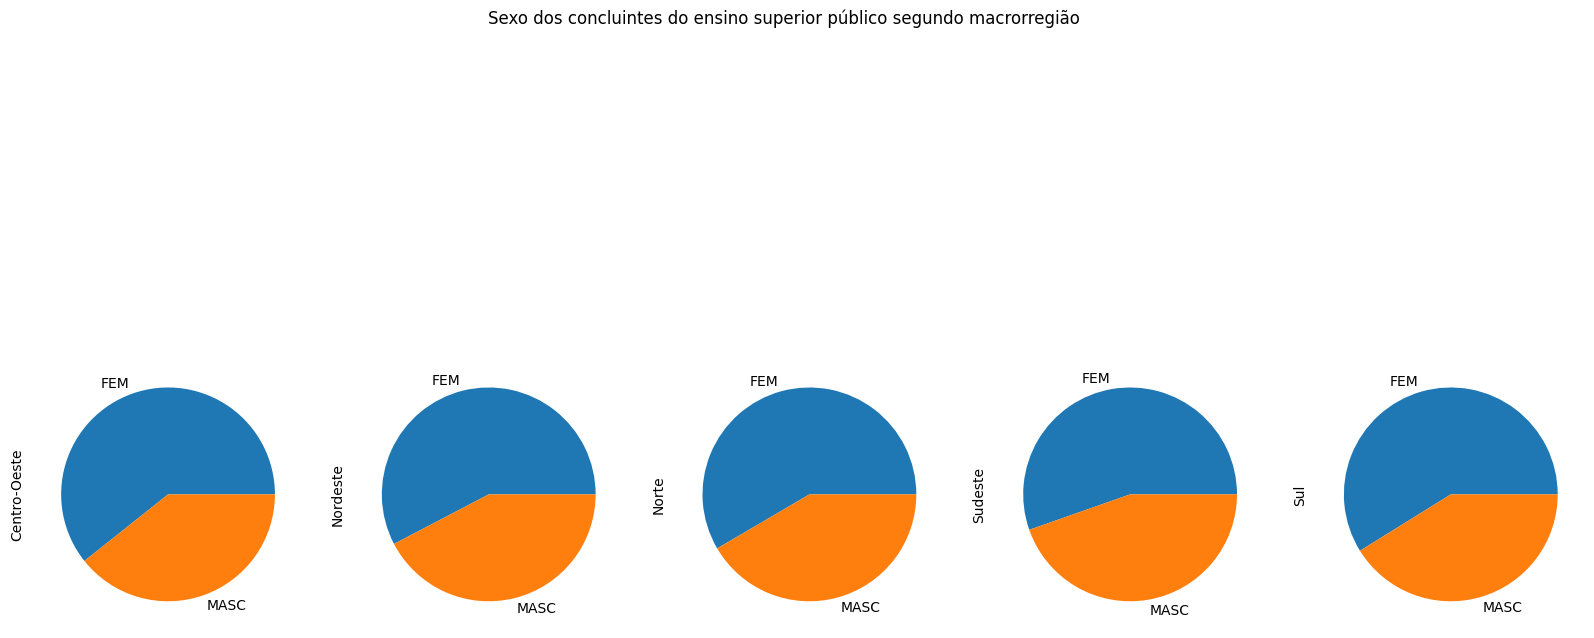

In [7]:
ingressantes.sexo.groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10), title = 'Sexo dos ingressantes do ensino superior público segundo macrorregião')
concluintes.sexo.groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10), title = 'Sexo dos concluintes do ensino superior público segundo macrorregião')

In [8]:
ingressantes.faixa_etaria = ingressantes.faixa_etaria.reset_index()
concluintes.faixa_etaria = concluintes.faixa_etaria.reset_index()

In [9]:
if not isdir(join(Path(getcwd()).parent,"exportacoes")):
    makedirs(join(Path(getcwd()).parent,"exportacoes"))

mapaFaixaEtariaIngressantesMedia = ingressantes.faixa_etaria.copy()
mapaFaixaEtariaIngressantesMedia['MEDIA'] = mapaFaixaEtariaIngressantesMedia.CO_MUNICIPIO.apply(lambda x: ingressantes.Media(x, 'CO_MUNICIPIO'))
mapaFaixaEtariaIngressantesMedia = mapaFaixaEtariaIngressantesMedia.merge(dados.municipios, on = 'CO_MUNICIPIO', how = 'left')

mapaFaixaEtariaConcluintesMedia = concluintes.faixa_etaria.copy()
mapaFaixaEtariaConcluintesMedia['MEDIA'] =  mapaFaixaEtariaConcluintesMedia.CO_MUNICIPIO.apply(lambda x: concluintes.Media(x, 'CO_MUNICIPIO'))
mapaFaixaEtariaConcluintesMedia = mapaFaixaEtariaConcluintesMedia.merge(dados.municipios, on = 'CO_MUNICIPIO', how = 'left')

mapaFaixaEtariaIngressantesMedia.loc[mapaFaixaEtariaIngressantesMedia.MEDIA == 0, 'MEDIA'] = None
mapaFaixaEtariaConcluintesMedia.loc[mapaFaixaEtariaConcluintesMedia.MEDIA == 0, 'MEDIA'] = None

/tmp/ipykernel_294/2902309128.py:81: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valor_medio = [(int(tupla[1])+1+int(tupla[0]))/2 for tupla in self.faixa_etaria.groupby(variavelAgrupamento).sum().columns]
/tmp/ipykernel_294/2902309128.py:82: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  faixa_etaria = self.faixa_etaria.groupby(variavelAgrupamento).sum().loc[self.faixa_etaria.groupby(variavelAgrupamento).sum().index == local].values[0]
/tmp/ipykernel_294/2902309128.py:82: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to 

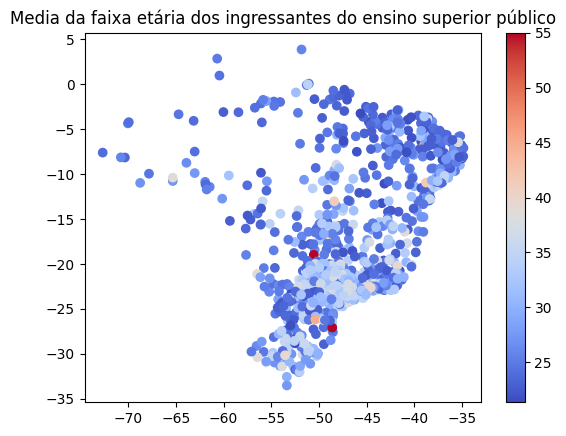

In [10]:
matplotlib.pyplot.scatter(y=mapaFaixaEtariaIngressantesMedia.LATITUDE, x=mapaFaixaEtariaIngressantesMedia.LONGITUDE, c =mapaFaixaEtariaIngressantesMedia.MEDIA, cmap="coolwarm")
matplotlib.pyplot.title('Media da faixa etária dos ingressantes do ensino superior público')
matplotlib.pyplot.colorbar()

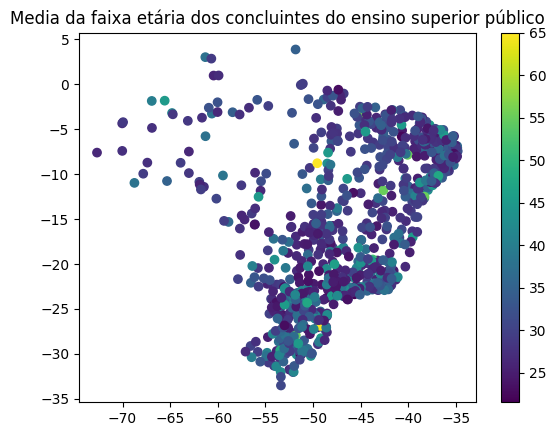

In [11]:
matplotlib.pyplot.scatter(y=mapaFaixaEtariaConcluintesMedia.LATITUDE, x=mapaFaixaEtariaConcluintesMedia.LONGITUDE, c =mapaFaixaEtariaConcluintesMedia.MEDIA, cmap="viridis")
matplotlib.pyplot.title('Media da faixa etária dos concluintes do ensino superior público')
matplotlib.pyplot.colorbar()

In [12]:
# RODA ISSO COM TEMPO PORQUE DEMORA UMA HORA E MEIA

# mapaFaixaEtariaIngressantesModa = ingressantes.faixa_etaria.copy()
# mapaFaixaEtariaIngressantesModa['MODA'] = mapaFaixaEtariaIngressantesModa.CO_MUNICIPIO.apply(lambda x: ingressantes.Moda(x, 'CO_MUNICIPIO'))
# mapaFaixaEtariaIngressantesModa = mapaFaixaEtariaIngressantesModa.merge(dados.municipios, on = 'CO_MUNICIPIO', how = 'left')

# mapaFaixaEtariaConcluintesModa = concluintes.faixa_etaria.copy()
# mapaFaixaEtariaConcluintesModa['MODA'] = mapaFaixaEtariaConcluintesModa.CO_MUNICIPIO.apply(lambda x: concluintes.Moda(x, 'CO_MUNICIPIO'))
# mapaFaixaEtariaConcluintesModa = mapaFaixaEtariaConcluintesModa.merge(dados.municipios, on = 'CO_MUNICIPIO', how = 'left')

# mapaFaixaEtariaIngressantesModa.loc[mapaFaixaEtariaIngressantesModa.MODA == 0, 'MODA'] = None
# mapaFaixaEtariaConcluintesModa.loc[mapaFaixaEtariaConcluintesModa.MODA == 0, 'MODA'] = None

In [13]:
# matplotlib.pyplot.scatter(y=mapaFaixaEtariaIngressantesModa.LATITUDE, x=mapaFaixaEtariaIngressantesModa.LONGITUDE, c =mapaFaixaEtariaIngressantesModa.MODA, cmap="coolwarm")
# matplotlib.pyplot.title('Moda da faixa etária dos ingressantes do ensino superior público')
# matplotlib.pyplot.colorbar()

In [14]:
# matplotlib.pyplot.scatter(y=mapaFaixaEtariaConcluintesModa.LATITUDE, x=mapaFaixaEtariaConcluintesModa.LONGITUDE, c = mapaFaixaEtariaConcluintesModa.MODA, cmap = 'viridis')
# matplotlib.pyplot.title('Moda da faixa etária dos concluintes do ensino superior público')
# matplotlib.pyplot.colorbar()